In [21]:
import pandas as pd
import numpy as np
import os
import json
from collections import Counter
import matplotlib.pyplot as plt

In [22]:
data_dir = './experiments-results/'
filenames = os.listdir(data_dir)
filenames[:] = [x for x in filenames if x[-5:] == '.json'] # only select .json files

In [23]:
results = {}
for fn in filenames:
    with open(f'{data_dir}/{fn}', 'r') as jsonfile:
        results[fn] = json.load(jsonfile)

In [24]:
d = {
    'seed': [],
    'p': [],
    'q': [],
    'ts': [],
    'e2e_ebits': [],
    'x_dist': [],
    # 'y_dist': [],
}

for k in results.keys():
    seed = results[k]['params_used']['seed']
    p = results[k]['params_used']['qc_p_loss_init']
    q = results[k]['params_used']['prob_swap_loss']
    # xdist = results[k]['params_used']['x_dist_gte']

    ts_with_ebits = list(Counter(results[k]['results']['time_slot']).keys())
    e2e_per_ts = list(Counter(results[k]['results']['time_slot']).values())
    for idx, ts in enumerate(ts_with_ebits):
        d['seed'].append(seed)
        d['p'].append(p)
        d['q'].append(q)
        xdist = int(ts - 1) # NOTE: --1 out of 2-- hacky way -- only applicable to this data where dist = ts-1.
        d['x_dist'].append(xdist)
        d['ts'].append(ts)
        d['e2e_ebits'].append(e2e_per_ts[idx])
    
    zero_ebits_ts = []
    for ts in range(2, results[k]['params_used']['num_ts'] + 1):
        if ts not in results[k]['results']['time_slot']:
            zero_ebits_ts.append(ts)

    for ts in zero_ebits_ts:
        d['seed'].append(seed)
        d['p'].append(p)
        d['q'].append(q)
        xdist = int(ts - 1) # NOTE: --2 out of 2-- hacky way -- only applicable to this data where dist = ts-1.
        d['x_dist'].append(xdist)
        d['ts'].append(ts)
        d['e2e_ebits'].append(0)

df = pd.DataFrame(data=d)

In [25]:
df

,seed,p,q,ts,e2e_ebits,x_dist
0,15,0.55,0.0,2,1,1
1,15,0.55,0.0,4,1,3
2,15,0.55,0.0,3,0,2
3,15,0.55,0.0,5,0,4
4,15,0.55,0.0,6,0,5
...,...,...,...,...,...,...
595,17,0.40,0.1,6,0,5
596,17,0.40,0.1,7,0,6
597,17,0.40,0.1,9,0,8
598,17,0.40,0.1,10,0,9


In [26]:
data = {
    'p': [],
    'q': [],
    'ebit_per_cycle': [],
    'x_dist': []
}

# ps = [0.4, 0.55, 0.7]
# qs = [0, 0.1, 0.5]
xs = range(1, 11)
pqs = [(0.55, 0), (0.4, 0.1), (0.4, 0)]

for p, q in pqs:
    for x in xs:
        val = df.loc[(df['p'] == p) & (df['q'] == q) & (df['x_dist'] == x)]['e2e_ebits'].mean()
        data['ebit_per_cycle'].append(np.log10(val))
        data['p'].append(p)
        data['q'].append(q)
        data['x_dist'].append(x)

plotdf = pd.DataFrame(data=data)

/tmp/ipykernel_1711718/2316055702.py:16: RuntimeWarning: divide by zero encountered in log10
  data['ebit_per_cycle'].append(np.log10(val))


Text(0, 0.5, 'log10( ebits/timeslot )')

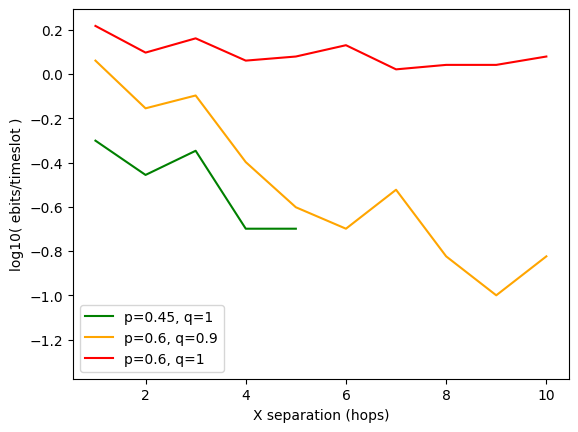

In [27]:
legend = []

p = 0.55
q = 0
legend.append(f"p={round(1-p, 2)}, q={1-q}")
color = 'green'
ax = plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)].plot(x='x_dist', y='ebit_per_cycle', logy=False, c=color)


# p = 0.55
# q = 0.1
# legend.append(f"p={round(1-p, 2)}, q={1-q}")
# color = 'purple'
# plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)].plot(x='x_dist', y='ebit_per_cycle', logy=False, c=color, ax=ax)


p = 0.4
q = 0.1
legend.append(f"p={1-p}, q={1-q}")
color = 'orange'
plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)].plot(x='x_dist', y='ebit_per_cycle', logy=False, c=color, ax=ax)

p = 0.4
q = 0
color = 'red'
legend.append(f"p={1-p}, q={1-q}")
plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)].plot(x='x_dist', y='ebit_per_cycle', logy=False, c=color, ax=ax)

ax.legend(legend)
ax.set_xlabel('X separation (hops)')
ax.set_ylabel('log10( ebits/timeslot )')

In [28]:
plotdf

,p,q,ebit_per_cycle,x_dist
0,0.55,0.0,-0.301030,1
1,0.55,0.0,-0.455932,2
2,0.55,0.0,-0.346787,3
3,0.55,0.0,-0.698970,4
4,0.55,0.0,-0.698970,5
5,0.55,0.0,-inf,6
6,0.55,0.0,-1.301030,7
7,0.55,0.0,-inf,8
8,0.55,0.0,-inf,9
9,0.55,0.0,-1.301030,10


In [29]:
xdist = 1
p, q = 0.4, 0.1 # orange
print('orange:', plotdf.loc[(plotdf['x_dist'] == xdist) & (plotdf['p'] == p) & (plotdf['q'] == q)]['ebit_per_cycle'])
p, q = 0.4, 0   # red
print('red:', plotdf.loc[(plotdf['x_dist'] == xdist) & (plotdf['p'] == p) & (plotdf['q'] == q)]['ebit_per_cycle'])
p, q = 0.55, 0  # green
print('green:', plotdf.loc[(plotdf['x_dist'] == xdist) & (plotdf['p'] == p) & (plotdf['q'] == q)]['ebit_per_cycle'])

orange: 10    0.060698
Name: ebit_per_cycle, dtype: float64
red: 20    0.217484
Name: ebit_per_cycle, dtype: float64
green: 0   -0.30103
Name: ebit_per_cycle, dtype: float64
